<br>

<center><img src="https://www.htu.edu.jo/images/ThumbnailsCoverPhotos/HTU%20Logo-250px.png" alt="HTU"  width="180px" align="center"> 


<br>

<p> 

**Artificial Intelligence & Intelligent Systems**

10204250

K/618/5660

Section (4)

**The foundations of AI and the development of an AI system**

**Submitted to**

Dr. Rami Ibrahim

**Submitted on**

June 20th, 2023

**Submitted by**

Marwan Tareq Shafiq Al Farah

**Student ID**

21110011

Spring 2022 – 2023
</p></center>

# **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping

# **Classes and Functions**

In [ ]:
class PredictionHistory(Callback):
    def __init__(self, X_test):
        self.X_test = X_test
        self.predictions = []

    def on_epoch_end(self, epoch, logs={}):
        self.predictions.append((self.model.predict(self.X_test) > 0.5).astype(int))

In [ ]:
def fill_list(arr, i, y_test, y_pred):
  arr[0][i] = accuracy_score(y_test,y_pred)
  arr[1][i] = precision_score(y_test,y_pred)
  arr[2][i] = recall_score(y_test,y_pred)
  arr[3][i] = f1_score(y_test,y_pred)

In [ ]:
def print_means(arr):
  print("Accuracy: ",arr[0].mean())
  print("Precision: ",arr[1].mean())
  print("Recall: ",arr[2].mean())
  print("F1_score: ",arr[3].mean()) 

In [ ]:
def print_charts(arrANN, arrRF, metric_name):
  labels = ['ANN', 'Random Forest']
  metric_means = [arrANN.mean(), arrRF.mean()]

  plt.figure(figsize=(8, 6))
  plt.bar(labels, metric_means)
  plt.xlabel('Model')
  plt.ylabel(metric_name)
  plt.title(metric_name + ' of ANN and Random Forest - Bar Chart')
  plt.ylim(0, 1)
  plt.show()

  metric_scores = [arrANN, arrRF]

  plt.figure(figsize=(8, 6))
  plt.boxplot(metric_scores, labels=labels)
  plt.xlabel('Model')
  plt.ylabel(metric_name)
  plt.title(metric_name + ' of ANN and Random Forest - Boxplot')
  plt.show()

# **Loading the Dataset**

In [ ]:
df = pd.read_csv('/content/adult.csv')

# **Dropping Null Values**

In [ ]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# **EDA**

<ipython-input-108-c555e47ab43e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


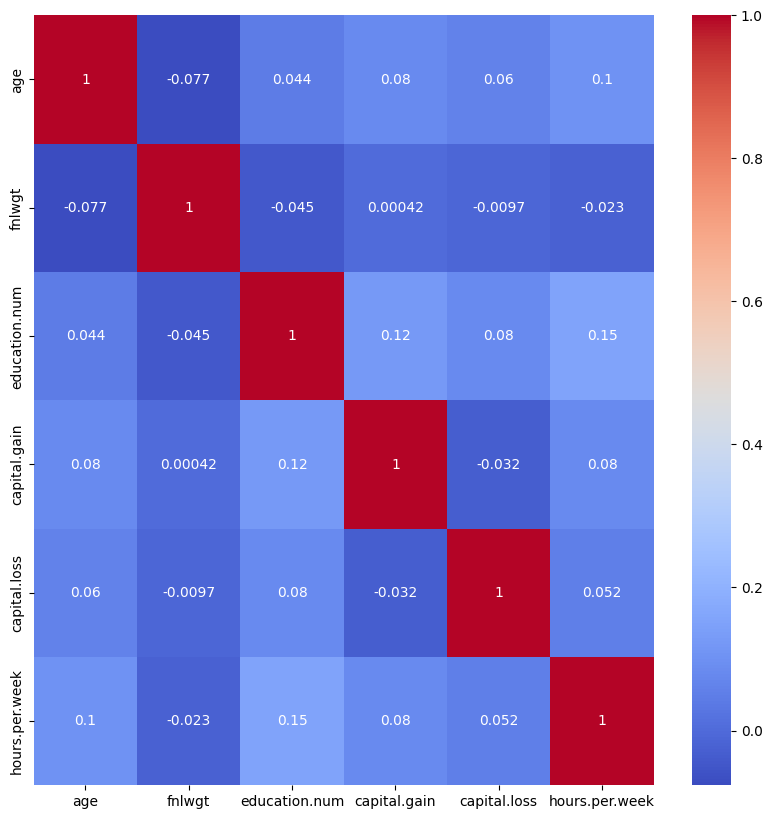

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

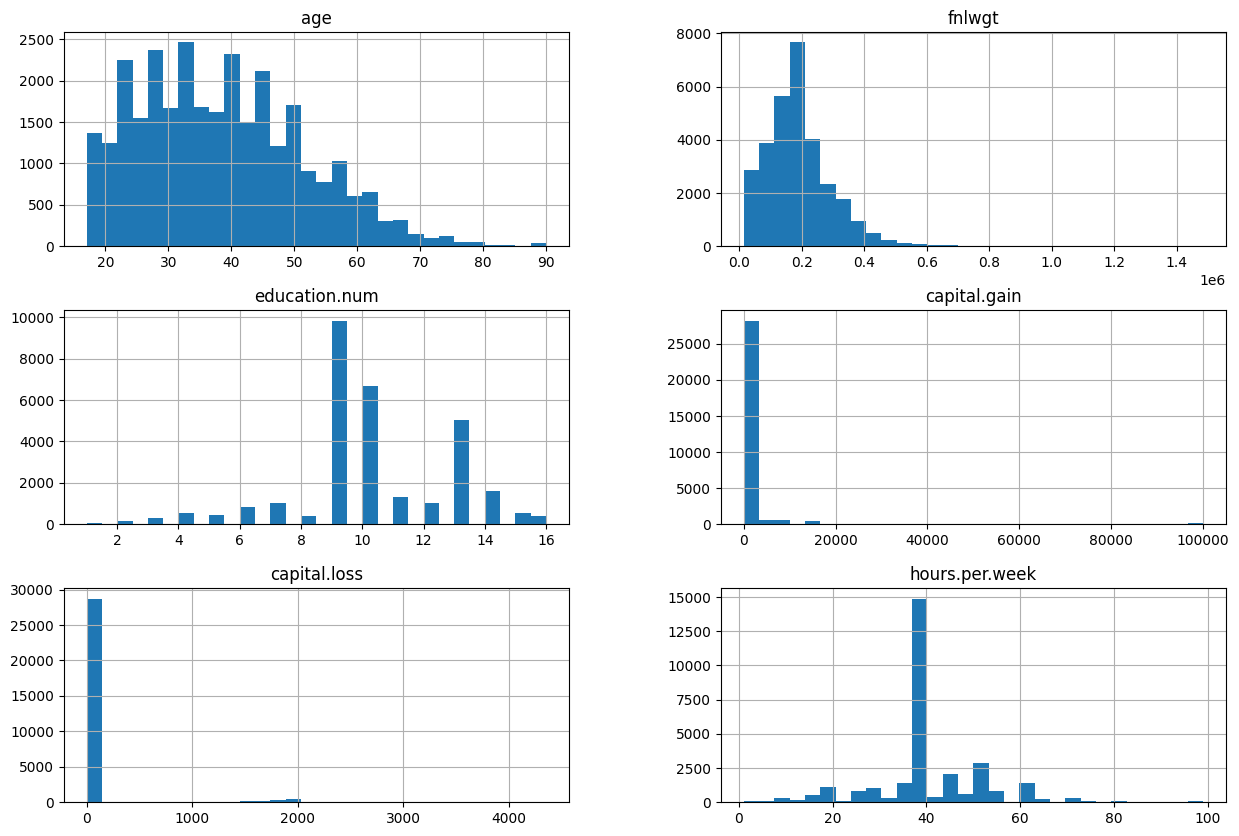

In [ ]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

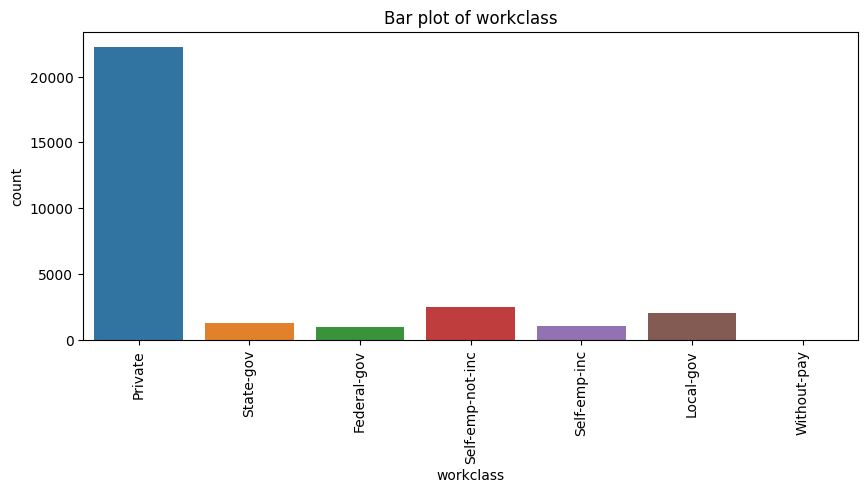

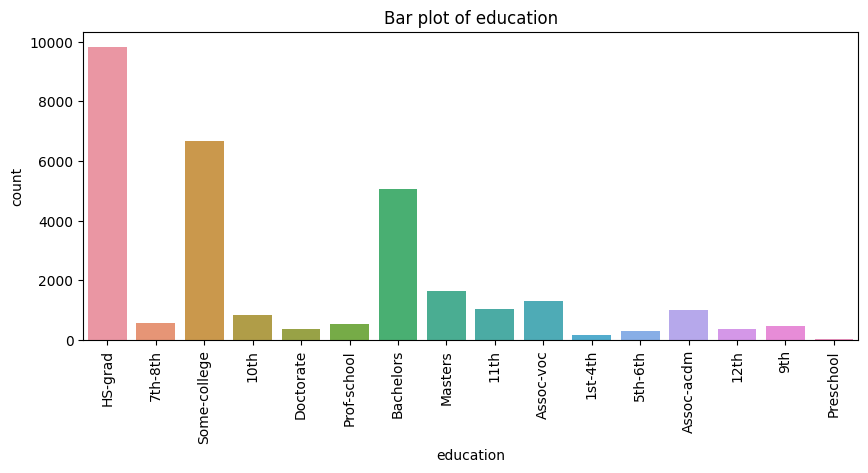

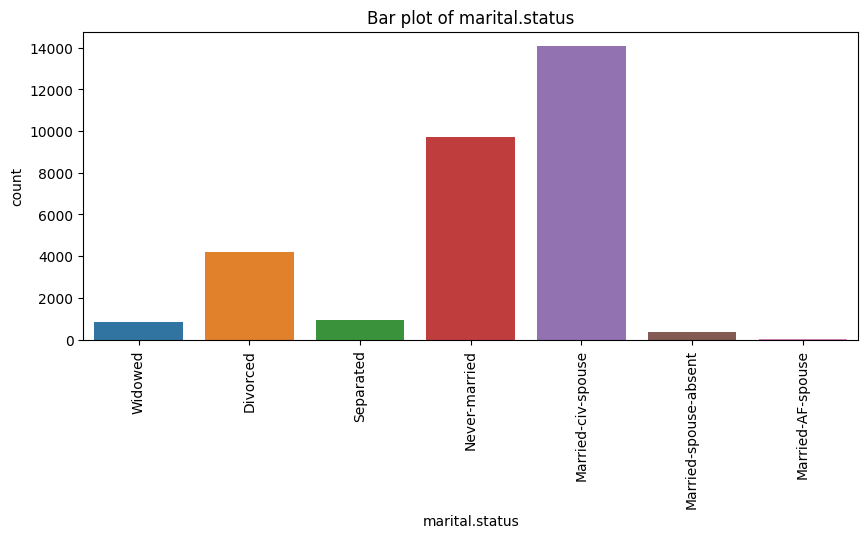

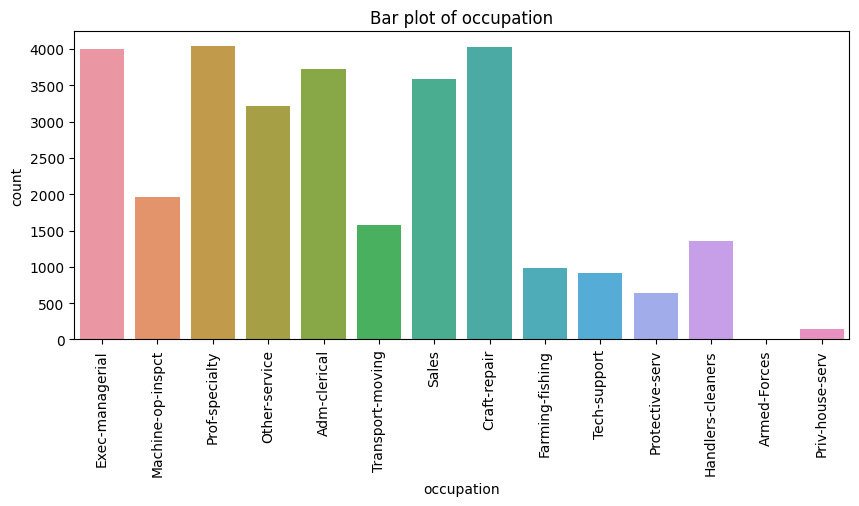

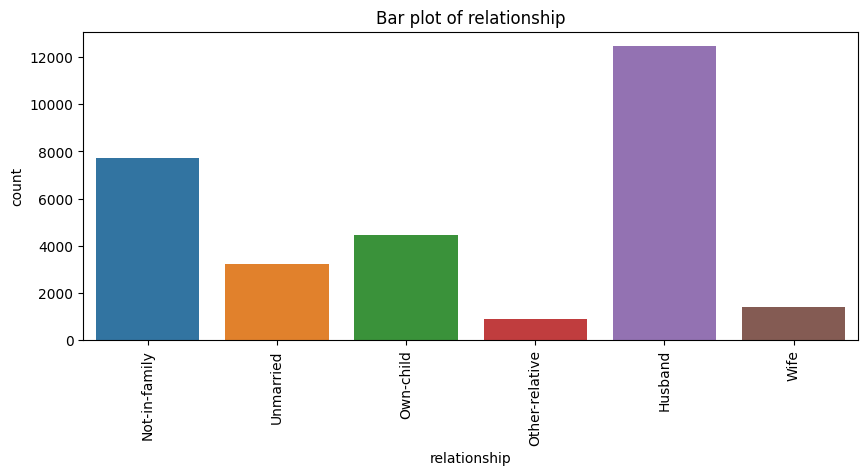

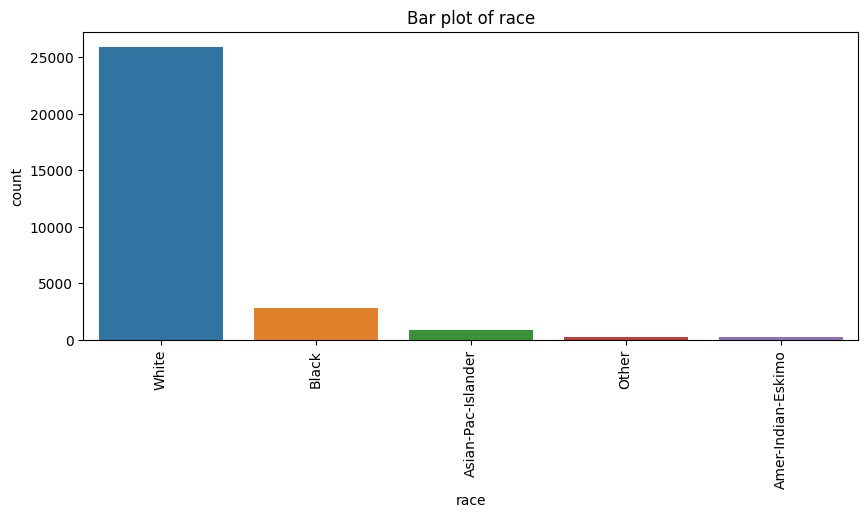

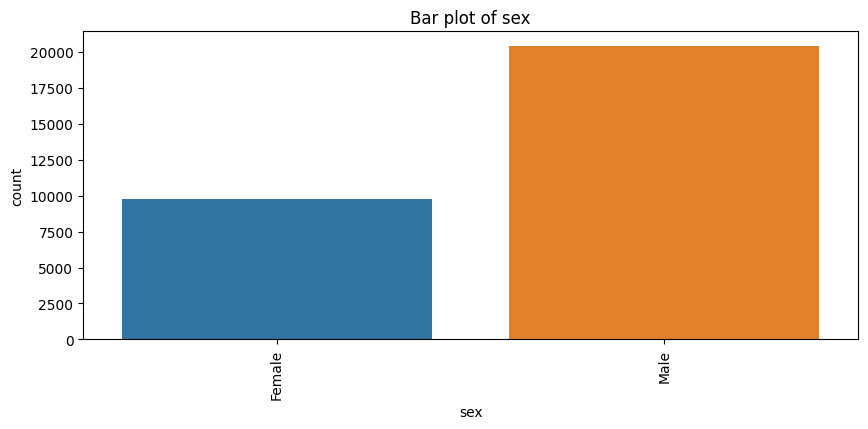

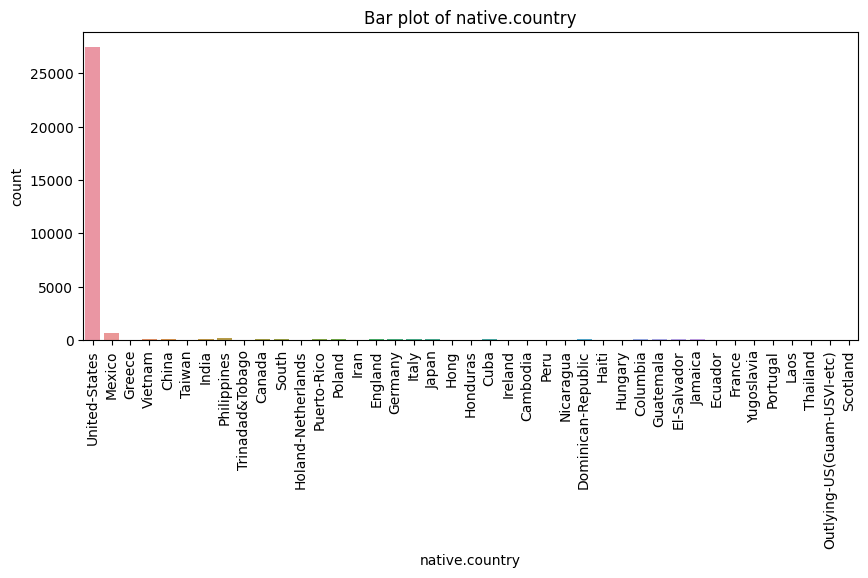

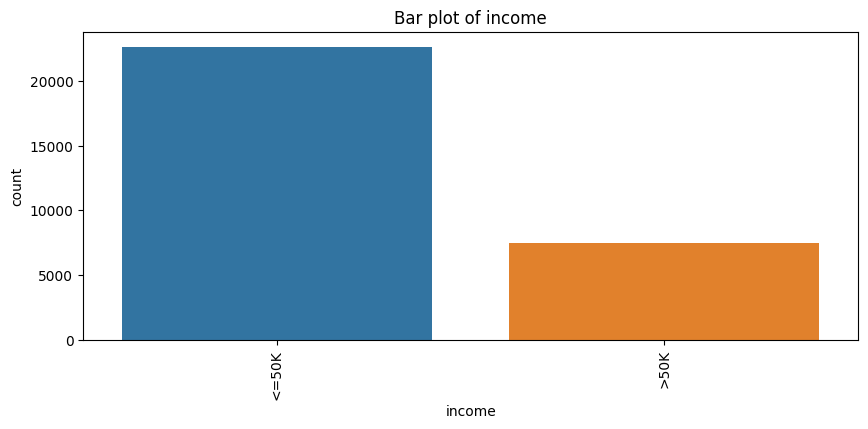

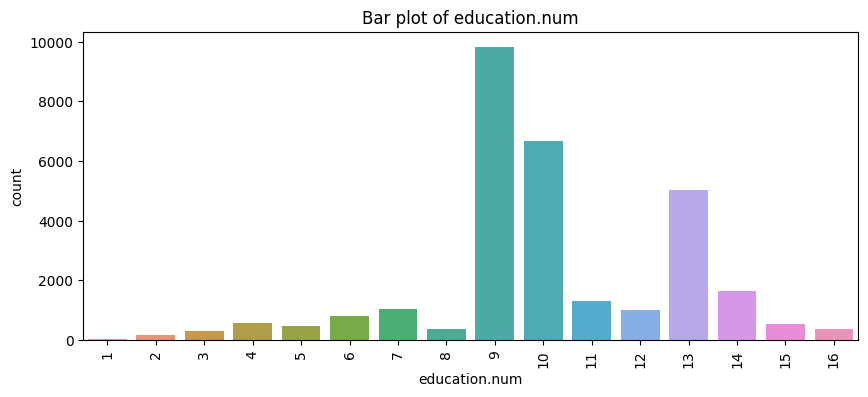

In [ ]:
cat_columns = list(df.select_dtypes(['object']).columns)
cat_columns.append('education.num')
for column in cat_columns:
    plt.figure(figsize=(10,4))
    sns.countplot(x=column, data=df)
    plt.title('Bar plot of '+column)
    plt.xticks(rotation=90)
    plt.show()

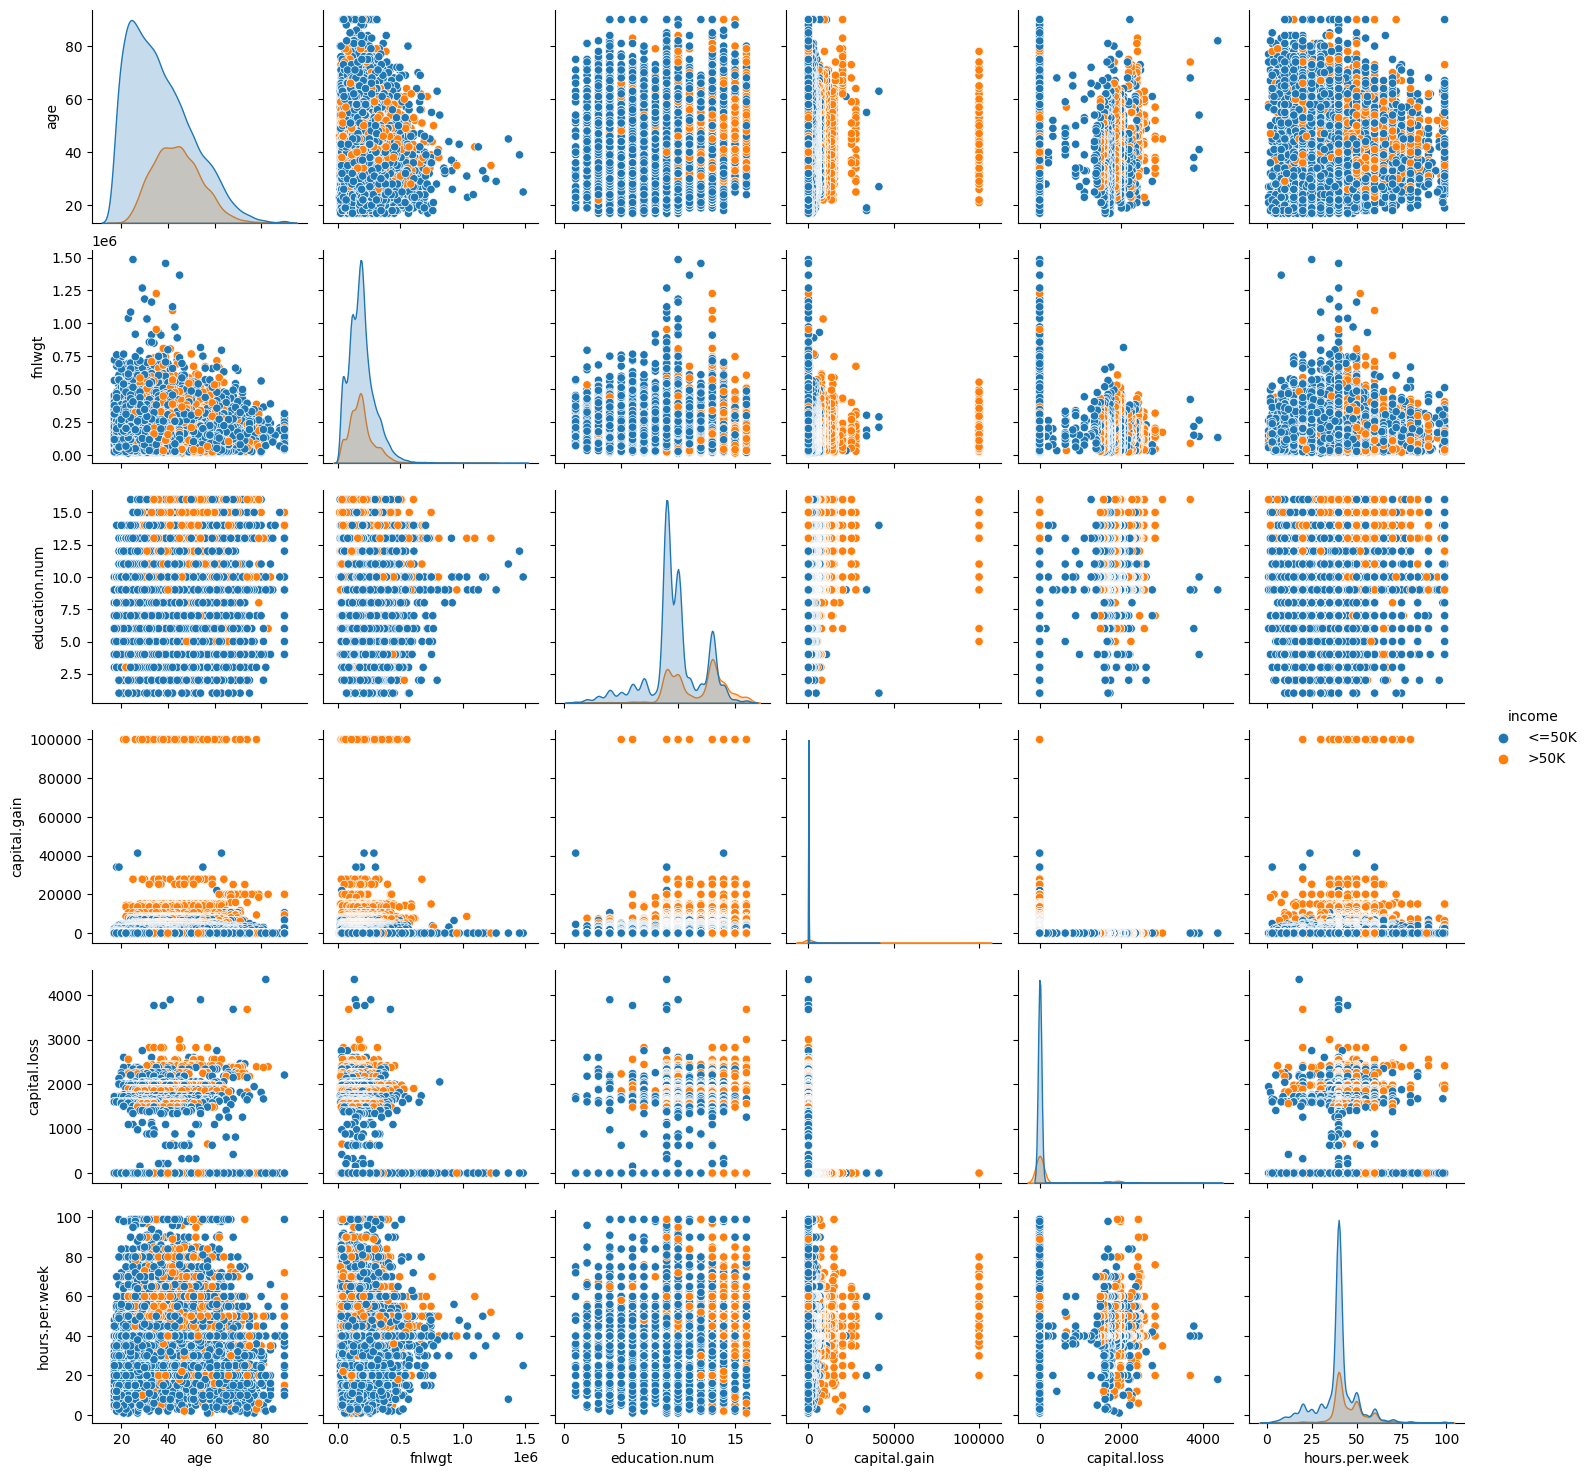

In [ ]:
numeric_columns = list(df.select_dtypes(exclude=['object']).columns)
sns.pairplot(df[numeric_columns + ['income']], vars=numeric_columns, hue='income')
plt.show()

# **Data Preprocessing**

## Encoding Catagorical Features

In [ ]:
LE = LabelEncoder()
df[cat_columns] = df[cat_columns].apply(lambda x : LE.fit_transform(x))

## Normalizing All Features

In [ ]:
df.iloc[:, :-1] = StandardScaler().fit_transform(df.iloc[:, :-1])

## Dropping Redundant Features

In [ ]:
education_mapping = df.groupby('education')['education.num'].unique()
matching_values = all(len(values) == 1 for values in education_mapping.values)
if matching_values:
    print("Every unique value in 'education' is matched by the same unique value in 'education.num'.")
    df.drop('education', axis=1, inplace=True)
else:
    print("There are unmatched values between 'education' and 'education.num'. No redundant column to drop.")

Every unique value in 'education' is matched by the same unique value in 'education.num'.


## Splitting the Dependent and Independent Features

In [ ]:
X = df.drop(['income'], axis = 1)
y = df['income']

# **Predictive Analytics**

## Random Forest Classifier

In [ ]:
n_iters = 20

In [ ]:
classiferRF = RandomForestClassifier(n_estimators = 20)
os = RandomOverSampler(sampling_strategy = 'minority')
arrRF = np.zeros((4,n_iters))
for i in range(n_iters):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=i)
  X_train, y_train = os.fit_resample(X_train, y_train)
  fill_list(arrRF, i, y_test, classiferRF.fit(X_train,y_train).predict(X_test))

In [ ]:
print_means(arrRF)

Accuracy:  0.8466570891811251
Precision:  0.6937431169527135
Recall:  0.6779396458145666
F1_score:  0.6857078765658973


## ANN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

prediction_history = PredictionHistory(X_test)

history = model.fit(X_train, y_train, epochs = 20, batch_size=20, validation_data=(X_test, y_test), callbacks=[early_stopping, prediction_history])

y_preds_array = np.array(prediction_history.predictions)
y_preds_array.reshape((y_preds_array.shape[0], y_preds_array.shape[1]))

arrANN = np.zeros((4,y_preds_array.shape[0]))
for j, i in enumerate(y_preds_array):
    fill_list(arrANN, j, y_test, i)

Epoch 1/20
1056/1056 [==============================] - 5s 3ms/step - loss: 0.3703 - accuracy: 0.8252 - val_loss: 0.3444 - val_accuracy: 0.8419
Epoch 2/20
1056/1056 [==============================] - 5s 5ms/step - loss: 0.3397 - accuracy: 0.8377 - val_loss: 0.3393 - val_accuracy: 0.8436
Epoch 3/20
1056/1056 [==============================] - 3s 3ms/step - loss: 0.3351 - accuracy: 0.8403 - val_loss: 0.3299 - val_accuracy: 0.8498
Epoch 4/20
1056/1056 [==============================] - 3s 3ms/step - loss: 0.3317 - accuracy: 0.8427 - val_loss: 0.3294 - val_accuracy: 0.8489
Epoch 5/20
1056/1056 [==============================] - 4s 3ms/step - loss: 0.3299 - accuracy: 0.8433 - val_loss: 0.3377 - val_accuracy: 0.8423
Epoch 6/20
1056/1056 [==============================] - 4s 4ms/step - loss: 0.3278 - accuracy: 0.8435 - val_loss: 0.3314 - val_accuracy: 0.8436
Epoch 7/20
1056/1056 [==============================] - 3s 3ms/step - loss: 0.3262 - accuracy: 0.8453 - val_loss: 0.3258 - val_accuracy:

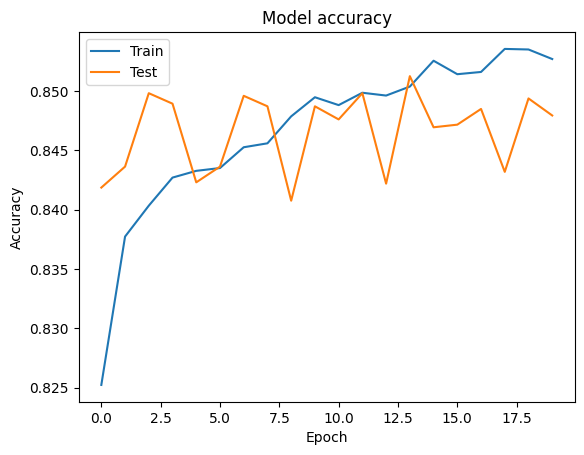

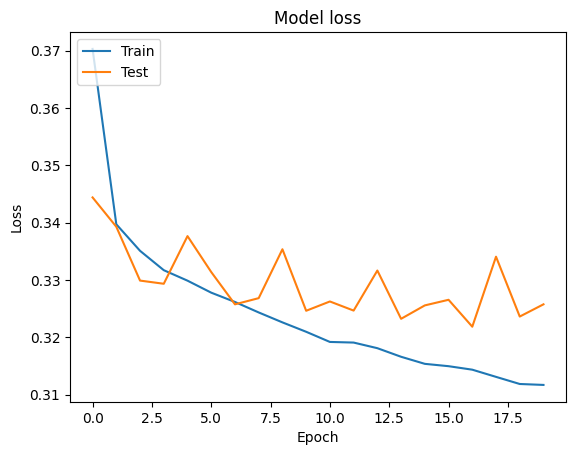

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
print_means(arrANN)

Accuracy:  0.8465963089844182
Precision:  0.767233778022138
Recall:  0.5713505244755244
F1_score:  0.6515669805810201


## Visualization of Evaluation Metrics

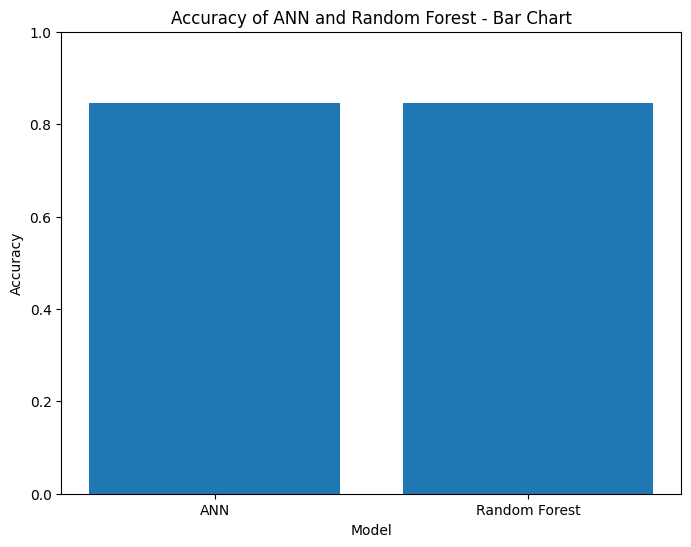

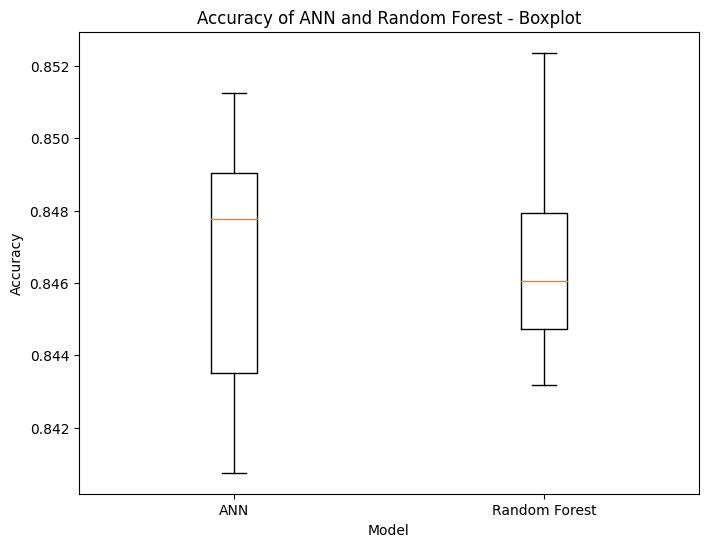

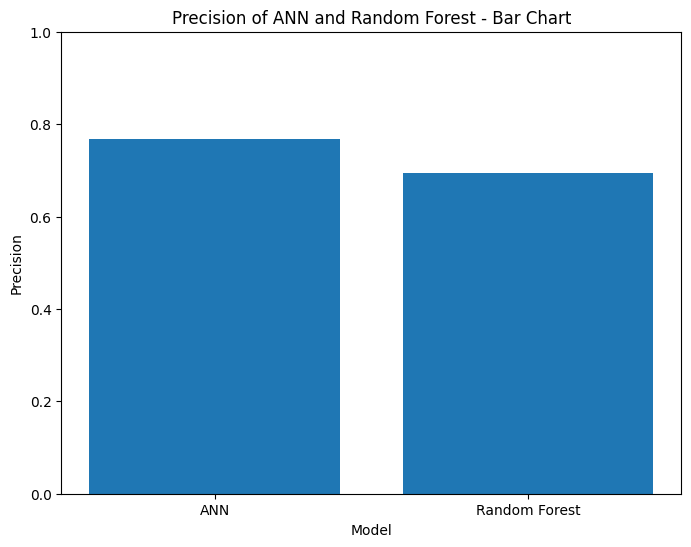

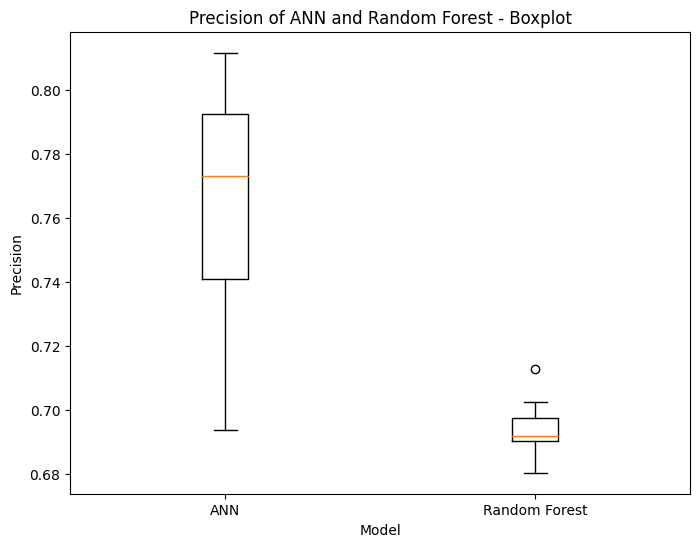

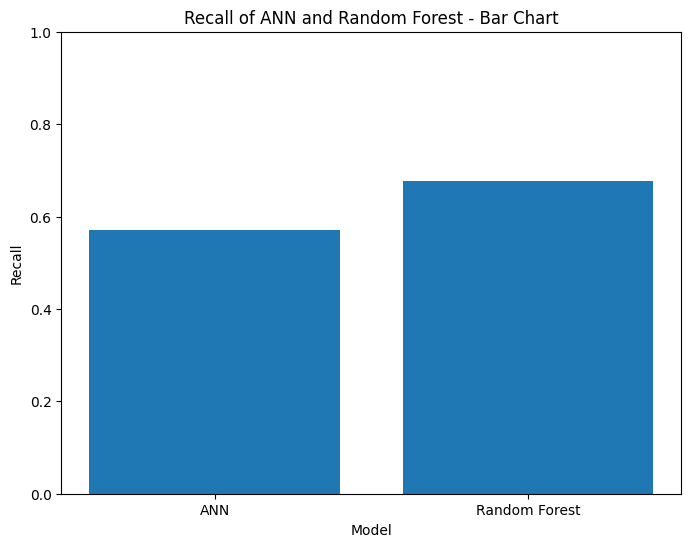

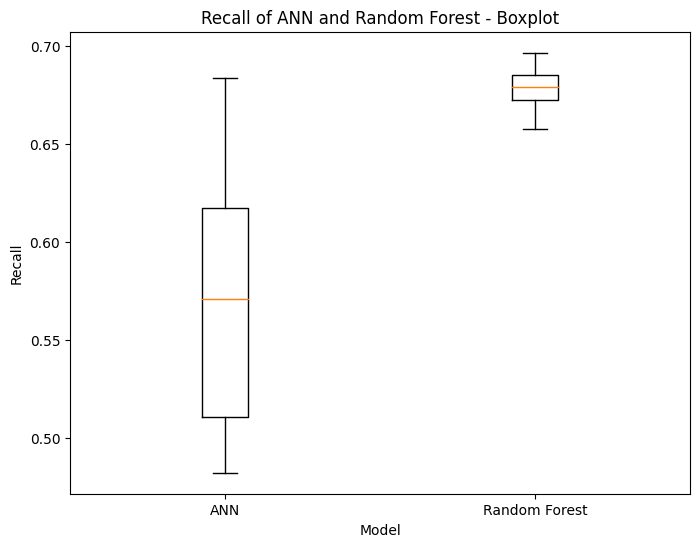

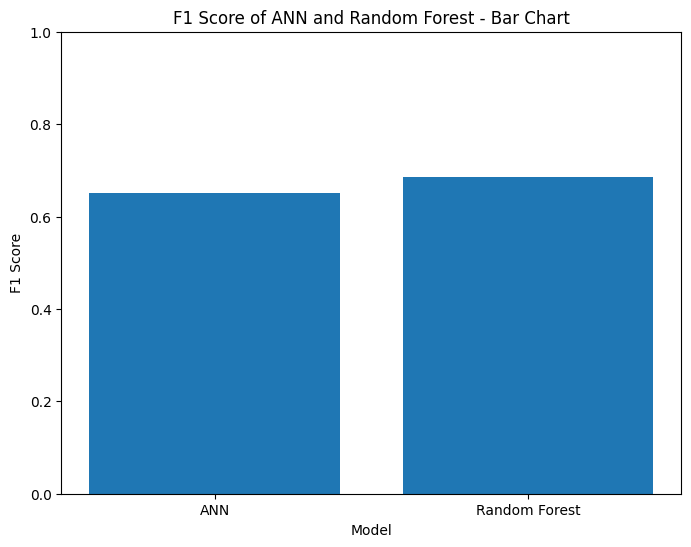

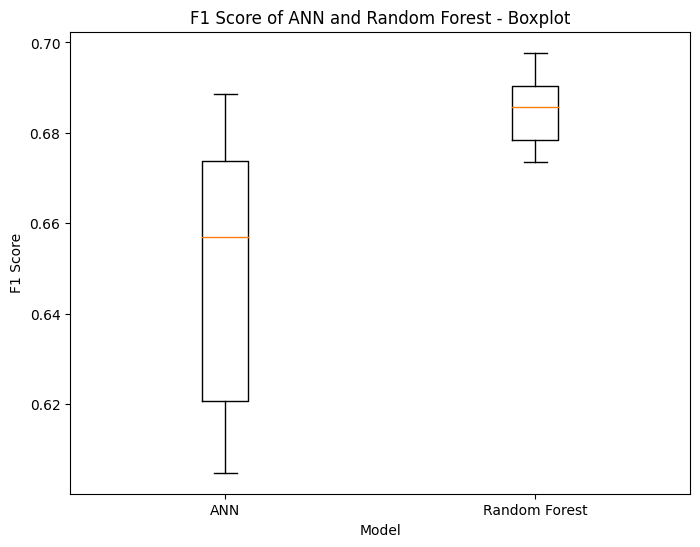

In [ ]:
print_charts(arrANN[0], arrRF[0], "Accuracy")
print_charts(arrANN[1], arrRF[1], "Precision")
print_charts(arrANN[2], arrRF[2], "Recall")
print_charts(arrANN[3], arrRF[3], "F1 Score")